В этом блоке обучаю модель на предсказание цен закрытия, максимальную и минимальную по акциям SBER.


# Загрузка библиотек

In [19]:
# данные
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.3f' % x)
import math

# подготовка данных
from sklearn.model_selection import train_test_split

# метрики
from sklearn.metrics import mean_absolute_percentage_error as mape

# отбор признаков
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression

# регресия
from sklearn.linear_model import LinearRegression

# сохранение/загрузка модели
from joblib import dump, load

# Загрузка и анализ данных

In [4]:
# прочитаем файл csv с историческими данными
parse_dates = ['<DATE>']
data = pd.read_csv('SBER_100101_230501.csv', parse_dates=parse_dates)
data.drop(columns=['<TICKER>', '<PER>', '<TIME>'], inplace=True)
data.head(2)

,<DATE>,<OPEN>,<HIGH>,<LOW>,<CLOSE>,<VOL>
0,2010-01-11,86.560,88.170,85.510,86.690,148661237
1,2010-01-12,86.550,86.770,84.900,85.000,130276079


In [5]:
# переименуем названия признаков в более удобные
data.rename(columns={'<TICKER>':'TICKER', '<DATE>':'DATE', '<OPEN>':'OPEN', '<HIGH>':'HIGH', 
                     '<LOW>':'LOW', '<CLOSE>':'CLOSE', '<VOL>':'VOL'}, inplace=True)

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   DATE    3333 non-null   datetime64[ns]
 1   OPEN    3333 non-null   float64       
 2   HIGH    3333 non-null   float64       
 3   LOW     3333 non-null   float64       
 4   CLOSE   3333 non-null   float64       
 5   VOL     3333 non-null   int64         
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 156.4 KB


<Axes: >

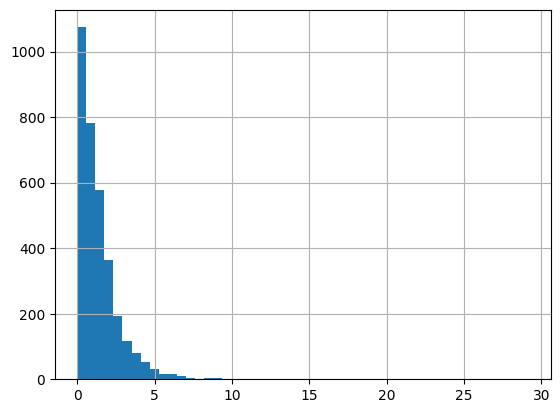

In [8]:
# на сколько процентов в среднем в день "ходит" цена
abs((data['OPEN'] - data['CLOSE']) / data['OPEN'] * 100).hist(bins=50)

In [9]:
(abs((data['OPEN'] - data['CLOSE']) / data['OPEN'] * 100)).describe()

count   3333.000
mean       1.378
std        1.467
min        0.000
25%        0.450
50%        1.018
75%        1.823
max       29.156
dtype: float64

## Удаление выбросов

In [10]:
data.loc[(data['OPEN'] - data['CLOSE']) / data['OPEN']*100 > 10]

,DATE,OPEN,HIGH,LOW,CLOSE,VOL
1240,2014-12-16,59.500,61.950,47.210,53.500,470470430
2070,2018-04-09,255.100,255.300,205.000,213.000,249893540
3050,2022-02-21,249.120,258.320,184.300,201.000,1084339130
3052,2022-02-24,186.580,187.540,89.590,132.180,828329350


In [11]:
drop_idx = data.loc[(data['OPEN'] - data['CLOSE']) / data['OPEN']*100 > 10].index
drop_idx

Int64Index([1240, 2070, 3050, 3052], dtype='int64')

In [12]:
data.drop(index=drop_idx, inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3329 entries, 0 to 3332
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   DATE    3329 non-null   datetime64[ns]
 1   OPEN    3329 non-null   float64       
 2   HIGH    3329 non-null   float64       
 3   LOW     3329 non-null   float64       
 4   CLOSE   3329 non-null   float64       
 5   VOL     3329 non-null   int64         
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 182.1 KB


<Axes: >

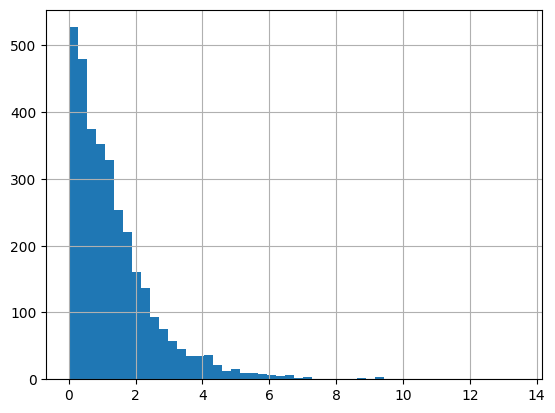

In [13]:
# без выбросов
abs((data['OPEN'] - data['CLOSE']) / data['OPEN'] * 100).hist(bins=50)

# Целевой признак

In [14]:
# целевой признак для регресии - это цена закрытия/максимум/минимум дня
# добавим его смещением признака с ценой закрытия вверх на единицу
data['TARGET_CLOSE'] = data['CLOSE'].shift(-1)
data['TARGET_HIGH'] = data['HIGH'].shift(-1)
data['TARGET_LOW'] = data['LOW'].shift(-1)
data.head(5)

,DATE,OPEN,HIGH,LOW,CLOSE,VOL,TARGET_CLOSE,TARGET_HIGH,TARGET_LOW
0,2010-01-11,86.560,88.170,85.510,86.690,148661237,85.000,86.770,84.900
1,2010-01-12,86.550,86.770,84.900,85.000,130276079,86.610,87.230,84.100
2,2010-01-13,84.400,87.230,84.100,86.610,128684773,87.550,87.870,86.750
3,2010-01-14,87.500,87.870,86.750,87.550,111263614,88.150,88.670,87.160
4,2010-01-15,87.470,88.670,87.160,88.150,142060148,90.490,90.650,87.790


In [15]:
# избавимся от nan-ов
data = data.dropna()

# Feature engineering

In [16]:
def features(data):

    # день недели
    data['DAY_OF_WEEK'] = data['DATE'].dt.dayofweek

    # месяц
    data['MONTH'] = data['DATE'].dt.month
    
    # разность между ценой открытия и закрытия
    data['DIF_O_C'] = data['OPEN'] - data['CLOSE']
    
    # разность между максимальной и минимальной ценой
    data['DIF_H_L'] = data['HIGH'] - data['LOW']

    # средние цены закрытия за ... дней
    data['MEAN_2'] = data['CLOSE'].rolling(window=2, center=False).mean()
    data['MEAN_3'] = data['CLOSE'].rolling(window=3, center=False).mean()
    data['MEAN_4'] = data['CLOSE'].rolling(window=4, center=False).mean()
    data['MEAN_5'] = data['CLOSE'].rolling(window=5, center=False).mean()

    # максимальные цены за ... дней
    data['HIGH_2'] = data['HIGH'].rolling(window=2, center=False).max()
    data['HIGH_3'] = data['HIGH'].rolling(window=3, center=False).max()
    data['HIGH_4'] = data['HIGH'].rolling(window=4, center=False).max()
    data['HIGH_5'] = data['HIGH'].rolling(window=5, center=False).max()

    # минимальные цены за ... дней
    data['LOW_2'] = data['LOW'].rolling(window=2, center=False).min()
    data['LOW_3'] = data['LOW'].rolling(window=3, center=False).min()
    data['LOW_4'] = data['LOW'].rolling(window=4, center=False).min()
    data['LOW_5'] = data['LOW'].rolling(window=5, center=False).min()
    
    # цены и объем за прошлые дни
    data[['OPEN_LAG_1', 'HIGH_LAG_1', 'LOW_LAG_1', 'CLOSE_LAG_1', 'VOL_LAG_1']] = data[['OPEN', 'HIGH', 'LOW', 'CLOSE', 'VOL']].shift(1)
    data[['OPEN_LAG_2', 'HIGH_LAG_2', 'LOW_LAG_2', 'CLOSE_LAG_2', 'VOL_LAG_2']] = data[['OPEN', 'HIGH', 'LOW', 'CLOSE', 'VOL']].shift(2)
    data[['OPEN_LAG_3', 'HIGH_LAG_3', 'LOW_LAG_3', 'CLOSE_LAG_3', 'VOL_LAG_3']] = data[['OPEN', 'HIGH', 'LOW', 'CLOSE', 'VOL']].shift(3)
    data[['OPEN_LAG_4', 'HIGH_LAG_4', 'LOW_LAG_4', 'CLOSE_LAG_4', 'VOL_LAG_4']] = data[['OPEN', 'HIGH', 'LOW', 'CLOSE', 'VOL']].shift(4)
    data[['OPEN_LAG_5', 'HIGH_LAG_5', 'LOW_LAG_5', 'CLOSE_LAG_5', 'VOL_LAG_5']] = data[['OPEN', 'HIGH', 'LOW', 'CLOSE', 'VOL']].shift(5)

  
    # цена открытия сегодня
    data['OPEN_TODAY'] = data['OPEN'].shift(-1)

    data.dropna(inplace=True)

    return pd.get_dummies(data, columns=['DAY_OF_WEEK', 'MONTH'], prefix=['DAY_OF_WEEK', 'MONTH'])

In [17]:
data1 = features(data.copy())
data1.head()

,DATE,OPEN,HIGH,LOW,CLOSE,VOL,TARGET_CLOSE,TARGET_HIGH,TARGET_LOW,DIF_O_C,...,MONTH_3,MONTH_4,MONTH_5,MONTH_6,MONTH_7,MONTH_8,MONTH_9,MONTH_10,MONTH_11,MONTH_12
5,2010-01-18,87.860,90.650,87.790,90.490,179399350,92.020,92.200,88.800,-2.630,...,0,0,0,0,0,0,0,0,0,0
6,2010-01-19,90.520,92.200,88.800,92.020,268915291,90.620,92.490,90.420,-1.500,...,0,0,0,0,0,0,0,0,0,0
7,2010-01-20,92.020,92.490,90.420,90.620,220273259,89.180,91.650,88.920,1.400,...,0,0,0,0,0,0,0,0,0,0
8,2010-01-21,91.260,91.650,88.920,89.180,219353508,86.500,89.060,85.750,2.080,...,0,0,0,0,0,0,0,0,0,0
9,2010-01-22,88.460,89.060,85.750,86.500,221223200,88.070,88.800,85.330,1.960,...,0,0,0,0,0,0,0,0,0,0


# Обучение

In [21]:
# модель для предсказания CLOSE
model_close = LinearRegression()

# предикторы
X = data1.drop(columns=['DATE', 'TARGET_CLOSE', 'TARGET_HIGH', 'TARGET_LOW'])
# целевой признак
y = data1['TARGET_CLOSE']

# разделим на трейн и тест без перемешивания
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

# отбор признаков
fs = SelectKBest(score_func=f_regression, k=30)
fs.fit(X_train, y_train)

# преобразования
X_train_fs = fs.transform(X_train)
X_test_fs = fs.transform(X_test)

# обучение и результаты
model_close.fit(X_train_fs, y_train)
y_pred_fs = model_close.predict(X_test_fs) 
mape(y_test, y_pred_fs)

0.014076077093609717

In [23]:
model_high = LinearRegression()

# предикторы
X = data1.drop(columns=['DATE', 'TARGET_CLOSE', 'TARGET_HIGH', 'TARGET_LOW'])
# целевой признак
y = data1['TARGET_HIGH']

# разделим на трейн и тест без перемешивания
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

# отбор признаков
fs = SelectKBest(score_func=f_regression, k=30)
fs.fit(X_train, y_train)

# преобразования
X_train_fs = fs.transform(X_train)
X_test_fs = fs.transform(X_test)

# обучение и результаты
model_high.fit(X_train_fs, y_train)
y_pred_fs = model_high.predict(X_test_fs) 
mape(y_test, y_pred_fs)

0.00856981881322237

In [24]:
# модель для предсказания LOW
model_low = LinearRegression()

# предикторы
X = data1.drop(columns=['DATE', 'TARGET_CLOSE', 'TARGET_HIGH', 'TARGET_LOW'])
# целевой признак
y = data1['TARGET_LOW']

# разделим на трейн и тест без перемешивания
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

# отбор признаков
fs = SelectKBest(score_func=f_regression, k=30)
fs.fit(X_train, y_train)

# преобразования
X_train_fs = fs.transform(X_train)
X_test_fs = fs.transform(X_test)

# обучение и результаты
model_high.fit(X_train_fs, y_train)
y_pred_fs = model_high.predict(X_test_fs) 
mape(y_test, y_pred_fs)

0.009030180342985859

# Сохранение моделей

In [25]:
dump(model_close, './saved_models/sber_model_close.joblib')

['./saved_models/sber_model_close.joblib']

In [26]:
dump(model_high, './saved_models/sber_model_high.joblib')

['./saved_models/sber_model_high.joblib']

In [27]:
dump(model_low, './saved_models/sber_model_low.joblib')

['./saved_models/sber_model_low.joblib']